# Handwritting Text Recognition CNN BiLSTM with CTC

This pipeline was implemented from [Naveen Reddy Marthala](https://github.com/naveenmarthala/Handwritten-word-recognition-OCR----IAM-dataset---CNN-and-BiRNN/blob/master/notebooks/iam%20on%20july%2025-CNN-BiLSTM.ipynb) Project. <br> But only recognize Alphanumeric character.

The trained model is only capable of recognizing short words composed of alphanumeric characters. It will not be able to predict or accurately handle punctuation, as those characters were deliberately excluded from the models vocabulary and the training data due to resource limitations.

## Import Libraries

In [1]:
import cv2
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import string
%matplotlib inline
import pandas as pd
import gc

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation

In [ ]:
# Config
DATA_DIR = "IAM_Words"
IMG_DIR = os.path.join(DATA_DIR, "words")
# ANNOTATION = os.path.join(DATA_DIR, "words.txt")
TRAIN_LABEL = os.path.join(DATA_DIR, "train_files.txt")
VALID_LABEL = os.path.join(DATA_DIR, "valid_files.txt")
TEST_LABEL = os.path.join(DATA_DIR, "test_files.txt")
MODEL = os.path.join("model", "HwTR_BiLSTM.h5")

Load image path with the given labels from dataset.
We select the datas which are not more than 16 length and not have punctuation.

In [4]:
def load_img_path_n_text(file):
    """
    read a string like(which can be found in each line of words.txt file):
    'a01-000u-00-00 ok 154 408 768 27 51 AT A'
    and extract 'a01-000u-00-00': location of the image with sub-folders, to read it from the directories
                'ok'            : processing status. ok means good, presumably.
                'A'             : ground truth text

    Then, pre-process using function defined above
    """
    
    dataset = []
    skipped = 0
    with open(file) as f:
        for line in f:
            if not line or line.startswith('#'):
                continue

            line_split = line.strip().split(' ')
            
            # not load 'err'
            if line_split[1] == 'err':
                skipped +=1
                continue

            dir_split = line_split[0].split('-')
            img_path = os.path.join(IMG_DIR, dir_split[0], f"{dir_split[0]}-{dir_split[1]}",f"{line_split[0]}.png")

            gt_text = ' '.join(line_split[8:])

            if len(gt_text) > 16:
                skipped+=1
                continue

            if any(ch in string.punctuation for ch in gt_text):
                skipped += 1
                continue
            
            # print(f"load : {img_path}, texts : {gt_text}")
            dataset.append([img_path, gt_text])

    print(f"skipped = {skipped}")
    return dataset

In [5]:
train_files = load_img_path_n_text(TRAIN_LABEL)
valid_files = load_img_path_n_text(VALID_LABEL)
test_files = load_img_path_n_text(TEST_LABEL)


skipped = 12404
skipped = 646
skipped = 584


In [6]:
print(f"Train = {len(train_files)}")
print(f"Valid = {len(valid_files)}")
print(f"Test = {len(test_files)}")

Train = 74888
Valid = 3670
Test = 3732


Then, we resize all images into same height and width. Then, we convert the images into a grayscale.

In [7]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # type: ignore

    img = img.astype(np.float32)
    img /= 255
    return img

In [8]:
letters = (
    [' '] +
    [str(d) for d in range(10)] +
    [chr(c) for c in range(ord('A'), ord('Z')+1)] +
    [chr(c) for c in range(ord('a'), ord('z')+1)]
)

blank_label = len(letters)

char_to_int = {c: i for i, c in enumerate(letters)}
int_to_char = {i: c for i, c in enumerate(letters)}

num_classes = len(letters) + 1  # +1 for CTC blank
print(num_classes)

64


In [ ]:
def text_to_labels(text):
    return np.array([char_to_int[c] for c in text], dtype=np.int32)


def labels_to_text(labels):
    result = []
    for l in labels:
        if l == blank_label:  # ignore CTC blank
            continue
        if l in int_to_char:
            result.append(int_to_char[l])
    return ''.join(result)


From some experiment, there is a image that cannot be read. Therefore, we delete it.

In [10]:
for index, (img_loc, gt_text) in enumerate(train_files):
    if 'r06-022-03-05' in img_loc:
        print(index)
        print(train_files[index])
        del train_files[index]
        print(train_files[index])
    else:
        continue

3936
['IAM_Words\\words\\r06\\r06-022\\r06-022-03-05.png', 'more']
['IAM_Words\\words\\g06\\g06-042e\\g06-042e-05-03.png', 'notice']


done


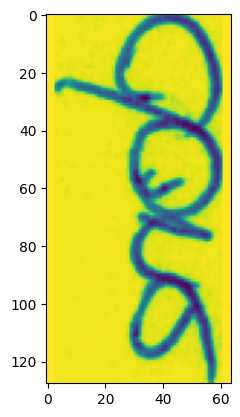

In [11]:
i = 21
print(train_files[i][1])
an_img = preprocess(path=train_files[i][0], img_w=128, img_h=64)
plt.imshow(an_img.T)

## Building Image data

In [12]:
class TextImageGenerator:
    def __init__(self, data, img_w, img_h,  batch_size,  i_len, max_text_len):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0

    def build_data(self):
        self.texts = [text for _, text in self.samples]
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        
        img_path, text = self.samples[self.indexes[self.cur_index]]
        img = preprocess(img_path, self.img_w, self.img_h)
        return img, text

    def next_batch(self):
        while True:
            X_data = np.ones((self.batch_size, self.img_w, self.img_h, 1), dtype=np.float32)
            Y_data = np.zeros((self.batch_size, self.max_text_len), dtype=np.int32)
            # timesteps = i_len (this should match the Reshape timesteps)
            input_length = np.ones((self.batch_size, 1), dtype=np.int32) * self.i_len
            label_length = np.zeros((self.batch_size, 1), dtype=np.int32)

            for i in range(self.batch_size):
                img, text = self.next_sample()
                # note: next_sample returns preprocess(img_path, img_w, img_h)
                # you used img.T in training flow — keep that consistent:
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img

                enc = text_to_labels(text)  # must return integer array/list
                Y_data[i, :len(enc)] = enc
                label_length[i, 0] = len(enc)

            inputs = {
                'input': X_data,
                'the_labels': Y_data,
                # choose either self.i_len OR (self.i_len - 2) depending on whether you slice y_pred
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = np.zeros((self.batch_size,), dtype=np.float32)
            yield (inputs, outputs)

    def peek_images(self, n=5):
        """
        Load and return the first n images and their texts for inspection.
        Does NOT preload the whole dataset.
        """
        peek_imgs = []
        peek_texts = []
        
        for i in range(min(n, self.n)):
            img_path, text = self.samples[i]
            img = preprocess(img_path, self.img_w, self.img_h)
            peek_imgs.append(img)
            peek_texts.append(text)
            
        return np.array(peek_imgs), peek_texts

In [13]:
BATCH_SIZE = 64
INPUT_LENGHT = 16
MAX_TEXT_LENGTH = 16
IMG_W = 128
IMG_H = 64

In [14]:
train_data = TextImageGenerator(train_files, IMG_W, IMG_H, BATCH_SIZE, INPUT_LENGHT, MAX_TEXT_LENGTH)
train_data.build_data()

In [15]:
images, texts = train_data.peek_images(n=3)
print("Peek images shape:", images.shape)  # (3, img_h, img_w)
print("Texts:", texts)

Peek images shape: (3, 64, 128)
Texts: ['policy', 'towns', 'Being']


In [15]:
valid_data = TextImageGenerator(valid_files, IMG_W, IMG_H, BATCH_SIZE, INPUT_LENGHT, MAX_TEXT_LENGTH)
valid_data.build_data()

In [17]:
images, texts = valid_data.peek_images(n=3)
print("Peek images shape:", images.shape)  # (3, img_h, img_w)
print("Texts:", texts)

Peek images shape: (3, 64, 128)
Texts: ['latter', 'possible', 'that']


In [18]:
del images, texts
gc.collect()

479

## MODELING

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as F

tf.keras.backend.set_image_data_format('channels_last')
tf.keras.backend.image_data_format()
     

'channels_last'

In [ ]:
input_data = tf.keras.layers.Input(name='input', shape=(IMG_W,IMG_H,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max1')(x)  # (None,64, 32, 64)

x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max2')(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='max3')(x)  # (None, 32, 8, 256)

x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='conv6')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='max4')(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max5')(x)

x = tf.keras.layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# CNN to RNN
x = tf.keras.layers.Reshape(target_shape=((16, 2048)), name='reshape')(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(x)

# RNN layer
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))(x)
x = tf.keras.layers.BatchNormalization()(x)

# transforms RNN output to character activations
x = tf.keras.layers.Dense(num_classes, kernel_initializer='he_normal', name='dense2')(x)
iam_outputs = tf.keras.layers.Activation('softmax', name='softmax')(x)

labels = tf.keras.layers.Input(name='the_labels', shape=[MAX_TEXT_LENGTH], dtype='int32')
label_length = tf.keras.layers.Input(name='label_length', shape=[1], dtype='int32')
input_length = tf.keras.layers.Input(name='input_length', shape=[1], dtype='int32')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss function
loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = tf.keras.Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 64)  256        ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                              

In [21]:
print("reshape output shape:", model.get_layer('reshape').output_shape)


reshape output shape: (None, 16, 2048)


In [22]:
inputs, outputs = next(train_data.next_batch())
print([ (k, v.shape, v.dtype) for k,v in inputs.items() ])
print("input_length sample:", inputs['input_length'][:5].T)
print("label_length sample:", inputs['label_length'][:5].T)


[('input', (64, 128, 64, 1), dtype('float32')), ('the_labels', (64, 16), dtype('int32')), ('input_length', (64, 1), dtype('int32')), ('label_length', (64, 1), dtype('int32'))]
input_length sample: [[16 16 16 16 16]]
label_length sample: [[5 5 3 4 3]]


In [22]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [24]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath=os.path.join("save", "{epoch:03}-val_loss{val_loss:.3f}.h5"),
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)
# reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [26]:
BATCH_SIZE, train_data.n, valid_data.n

(64, 74887, 3670)

## Training

In [27]:
EPOCHS = 30

In [28]:
history_model_3 = model.fit(train_data.next_batch(),
                            validation_data=valid_data.next_batch(),
                            steps_per_epoch=train_data.n/BATCH_SIZE,
                            validation_steps=valid_data.n // BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[earlystop, model_save_cb, epoch_times])

Epoch 1/30
1171/1170 [==============================] - ETA: 0s - loss: 8.4309 ;validation took 0.4067 minutes.

Epoch 1: saving model to save\001-val_loss3.849.h5
 ;epoch 1 took 17.399 minutes.
1170/1170 [==============================] - 1044s 868ms/step - loss: 8.4309 - val_loss: 3.8493
Epoch 2/30
1171/1170 [==============================] - ETA: 0s - loss: 2.6854 ;validation took 0.0899 minutes.

Epoch 2: saving model to save\002-val_loss2.537.h5
 ;epoch 2 took 6.6407 minutes.
1170/1170 [==============================] - 398s 341ms/step - loss: 2.6854 - val_loss: 2.5369
Epoch 3/30
1171/1170 [==============================] - ETA: 0s - loss: 1.8314 ;validation took 0.0961 minutes.

Epoch 3: saving model to save\003-val_loss1.967.h5
 ;epoch 3 took 7.0721 minutes.
1170/1170 [==============================] - 424s 363ms/step - loss: 1.8314 - val_loss: 1.9666
Epoch 4/30
1171/1170 [==============================] - ETA: 0s - loss: 1.4075 ;validation took 0.2701 minutes.

Epoch 4: saving 

In [29]:
model.save(MODEL)

In [ ]:
del train_data, valid_data, train_files
gc.collect()

4

## Plotting

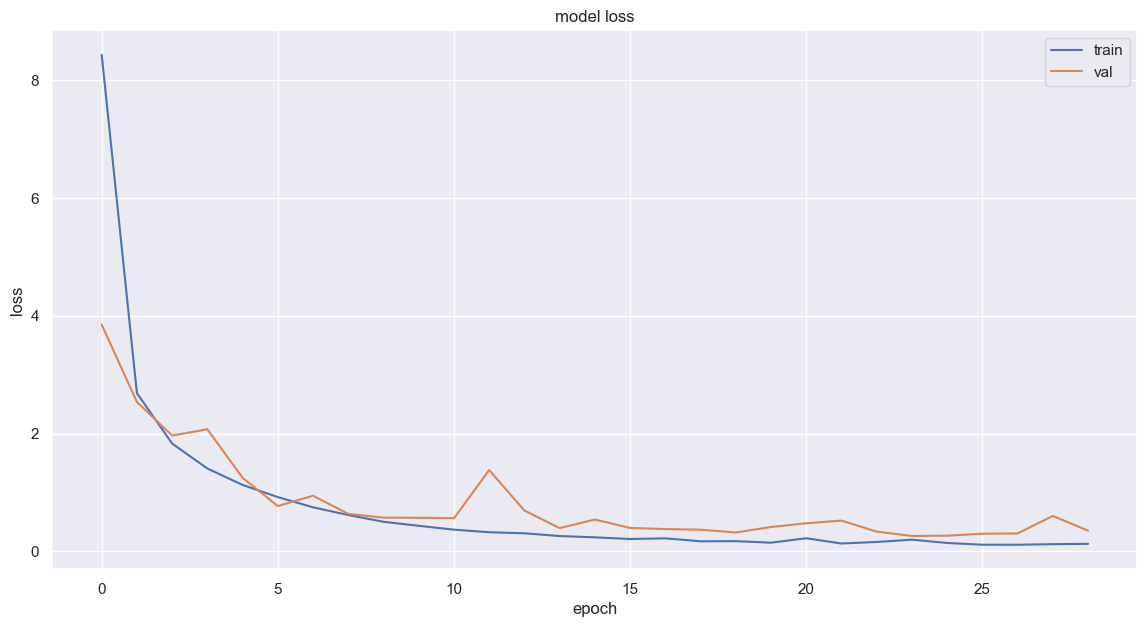

In [31]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [32]:
history_model_3.history.keys()

dict_keys(['loss', 'val_loss'])

## Evaluation

In [33]:
loss_df = pd.DataFrame(data=history_model_3.history)
loss_df.head()

,loss,val_loss
0,8.430922,3.849304
1,2.685431,2.536881
2,1.831419,1.966625
3,1.407539,2.073718
4,1.128729,1.249540


In [34]:
loss_df.sort_values(by=['loss', 'val_loss']).head()

,loss,val_loss
26,0.113397,0.305861
25,0.113712,0.300645
27,0.123294,0.603189
28,0.129212,0.351999
21,0.134818,0.523377


## Prediction and CER WER metrics

In [31]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test_files):
     temp_processed_image = preprocess(path=test_image_path, img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

valid_images_processed = []
original_valid_texts = []
for _, (valid_image_path, original_valid_text) in enumerate(valid_files):
     temp_processed_image = preprocess(path=valid_image_path, img_w=128, img_h=64)
     valid_images_processed.append(temp_processed_image.T)
     original_valid_texts.append(original_valid_text)

In [32]:
test_images_processed = np.array(test_images_processed)
test_images_processed = test_images_processed.reshape(len(test_files), 128, 64, 1)
print(test_images_processed.shape)

valid_images_processed = np.array(valid_images_processed)
valid_images_processed = valid_images_processed.reshape(len(valid_files), 128, 64, 1)
print(valid_images_processed.shape)

(3732, 128, 64, 1)
(3670, 128, 64, 1)


In [33]:
model_pred = None
model_pred = Model(inputs=input_data, outputs=iam_outputs)
model_pred.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 64, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 128, 64, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 64, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 32, 128)       73856     
                                                           

In [34]:
model_pred.load_weights(MODEL)

In [35]:
test_predictions_encoded = model_pred.predict(x=test_images_processed)
print(test_predictions_encoded.shape)
valid_predictions_encoded = model_pred.predict(x=valid_images_processed)
print(valid_predictions_encoded.shape)

117/117 [==============================] - 22s 43ms/step
(3732, 16, 64)
115/115 [==============================] - 5s 43ms/step
(3670, 16, 64)


In [36]:
# use CTC decoder to decode to text
test_predictions_decoded = F.get_value(F.ctc_decode(test_predictions_encoded,
    input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
    greedy=True)[0][0])
print(test_predictions_decoded.shape)

valid_predictions_decoded = F.get_value(F.ctc_decode(valid_predictions_encoded,
    input_length = np.ones(valid_predictions_encoded.shape[0])*valid_predictions_encoded.shape[1],
    greedy=True)[0][0])
print(valid_predictions_decoded.shape)

(3732, 16)
(3670, 16)


In [37]:
def numbered_array_to_text(numbered_array):
    numbered_array = numbered_array[numbered_array != -1]
    return "".join(letters[i] for i in numbered_array)

In [38]:
for i in range(3):
    print("original_text = ", original_test_texts[i])
    print("predicted text = ", numbered_array_to_text(test_predictions_decoded[i]))
    print()

original_text =  certain
predicted text =  certain

original_text =  biographies
predicted text =  biographies

original_text =  all
predicted text =  all



Calculate the WER and CER

In [40]:
#define function
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        new_distances = [i2 + 1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                cost = 0
            else:
                cost = 1
            new_distances.append(min(new_distances[-1] + 1,
                                     distances[i1] + cost,
                                     distances[i1 + 1] + 1))
        distances = new_distances
    return distances[-1]

def calculate_cer_manual(original_text, predicted_text):
    distance = levenshtein_distance(original_text, predicted_text)
    total_chars = len(original_text)
    if total_chars == 0:
        return 0.0
    return distance / total_chars

def calculate_wer_manual(original_text, predicted_text):
    original_words = original_text.split()
    predicted_words = predicted_text.split()
    distance = levenshtein_distance(original_words, predicted_words)
    total_words = len(original_words)
    if total_words == 0:
        return 0.0
        
    return distance / total_words



CER and WER using test dataset

In [41]:
all_cer_scores = []
all_wer_scores = []

for i in range(len(original_test_texts)):
    original_text = original_test_texts[i]
    predicted_text_raw = numbered_array_to_text(test_predictions_decoded[i])
    
    predicted_text = ' '.join(predicted_text_raw.split()).strip()

    cer_score = calculate_cer_manual(original_text, predicted_text)
    wer_score = calculate_wer_manual(original_text, predicted_text)
    
    all_cer_scores.append(cer_score)
    all_wer_scores.append(wer_score)

    if i < 10:
        print(f"Original: {original_text}")
        print(f"Predicted: {predicted_text}")
        print(f"CER: {cer_score:.4f}, WER: {wer_score:.4f}\n")

final_avg_cer = np.mean(all_cer_scores)
final_avg_wer = np.mean(all_wer_scores)

print("="*40)
print(f"FINAL AVERAGE CER: {final_avg_cer:.4f}")
print(f"FINAL AVERAGE WER: {final_avg_wer:.4f}")
print("="*40)

Original: certain
Predicted: certain
CER: 0.0000, WER: 0.0000

Original: biographies
Predicted: biographies
CER: 0.0000, WER: 0.0000

Original: all
Predicted: all
CER: 0.0000, WER: 0.0000

Original: It
Predicted: It
CER: 0.0000, WER: 0.0000

Original: I
Predicted: I
CER: 0.0000, WER: 0.0000

Original: show
Predicted: show
CER: 0.0000, WER: 0.0000

Original: Kings
Predicted: Kings
CER: 0.0000, WER: 0.0000

Original: A
Predicted: A
CER: 0.0000, WER: 0.0000

Original: the
Predicted: the
CER: 0.0000, WER: 0.0000

Original: and
Predicted: and
CER: 0.0000, WER: 0.0000

FINAL AVERAGE CER: 0.0122
FINAL AVERAGE WER: 0.0509


CER and WER using validation dataset

In [42]:
all_cer_scores = []
all_wer_scores = []

for i in range(len(original_valid_texts)):
    original_text = original_valid_texts[i]
    predicted_text_raw = numbered_array_to_text(valid_predictions_decoded[i])
    
    predicted_text = ' '.join(predicted_text_raw.split()).strip()

    cer_score = calculate_cer_manual(original_text, predicted_text)
    wer_score = calculate_wer_manual(original_text, predicted_text)
    
    all_cer_scores.append(cer_score)
    all_wer_scores.append(wer_score)

    if i < 10:
        print(f"Original: {original_text}")
        print(f"Predicted: {predicted_text}")
        print(f"CER: {cer_score:.4f}, WER: {wer_score:.4f}\n")

final_avg_cer = np.mean(all_cer_scores)
final_avg_wer = np.mean(all_wer_scores)

print("="*40)
print(f"FINAL AVERAGE CER: {final_avg_cer:.4f}")
print(f"FINAL AVERAGE WER: {final_avg_wer:.4f}")
print("="*40)

Original: latter
Predicted: latter
CER: 0.0000, WER: 0.0000

Original: possible
Predicted: possible
CER: 0.0000, WER: 0.0000

Original: that
Predicted: that
CER: 0.0000, WER: 0.0000

Original: at
Predicted: at
CER: 0.0000, WER: 0.0000

Original: again
Predicted: again
CER: 0.0000, WER: 0.0000

Original: on
Predicted: on
CER: 0.0000, WER: 0.0000

Original: original
Predicted: original
CER: 0.0000, WER: 0.0000

Original: earlier
Predicted: earlier
CER: 0.0000, WER: 0.0000

Original: Berlin
Predicted: Berlin
CER: 0.0000, WER: 0.0000

Original: in
Predicted: in
CER: 0.0000, WER: 0.0000

FINAL AVERAGE CER: 0.0124
FINAL AVERAGE WER: 0.0485
